<a href="https://colab.research.google.com/github/pedro-de-bastos/Capstone/blob/master/Capstone_Notebook_3_Modelling_in_R_Regression_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling in R - Regression and Classification

By: Pedro Martins de Bastos

## Importing the Data

The code below imports the data that has already been processed and saved in my google drive. Therefore, the "creating CSVs" section was only used to create that data in the first place, and now I only import the data to trian my models below.

In [ ]:
## Clear the csv files
files <- list.files(pattern = "\\.csv$")
for (i in files){
  unlink(i)
}

#"Data" corresponds to the CSV files with the judgement score results
prof_talk_times <- function(data, inst_name){
  data$Judgement = data$Score*data$Magnitude
  files <- c('Class_1.1.csv', 'Class_1.2.csv', 'Class_2.1.csv', 'Class_2.2.csv', 'Class_3.1.csv', 'Class_3.2.csv', 'Class_4.1.csv', 'Class_4.2.csv', 'Class_5.1.csv', 'Class_5.2.csv', 'Class_6.2.csv', 'Class_7.1.csv', 'Class_7.2.csv', 'Class_8.1.csv', 'Class_8.2.csv', 'Class_9.1.csv', 'Class_9.2.csv', 'Class_10.1.csv', 'Class_10.2.csv')
  means = c()
  sds = c()
  prof_talk_time = c()

  for (i in files){
    means <- c(means, mean(csv_to_mean_sd(i, inst_name)))
    sds <- c(sds, sd(csv_to_mean_sd(i, inst_name)))
    prof_talk_time <- c(prof_talk_time, prof_talk(i, inst_name))
  }

  data$Talk_Means = means
  data$Talk_SDs = sds
  data$Prof_Talk_Time = prof_talk_time

  data$Prep.Mean[is.na(data$Prep.SD)] = 0
  data$Prep.SD[is.na(data$Prep.SD)] = 0
  data$Video.SD[is.na(data$Video.SD)] = 0
  data$Video.Mean[is.na(data$Video.Mean)] = 0

  data$Grades.Mean = data$Prep.Mean + data$Video.Mean
  data$Grades.SD = data$Prep.SD + data$Video.SD

  data = data[data$Grades.Mean != 0,]

  return (data)
}

terrana = read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSXqU-zIOsWPPEB8w328WdNPVUJ9Z-9SJVpz68FWhGRW_KsSxXvf3u6154cwLB7b7NfQwK5CLZF09lE/pub?output=csv")
dosmann = read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQHL1HX6rjAObBwVnXoyXx8fZtMKo72KPZ8ZXiFTrWU2misiEuPCuYm6jbX-WWYIKbNqAzxtIa5JhIO/pub?output=csv")
mcallister = read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRUnJvneBbREz9JOEiIfhi_mNU07j2dZXNNx_TTZVeMpnD9zGjvPPAlh2Ip4k4t4yEh3JBCrSjF961X/pub?output=csv")
mcallister = mcallister[mcallister$Grades.Mean<5,]
fiorelli = read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQiNPjHxocAMRIvIheSxvuHrw9kN9qlO-mnb9uQY4BSrGDnSP2yKAFtmWrYO9YEfvM8QaU-slY91A5k/pub?output=csv")

datas = list(terrana, dosmann, mcallister, fiorelli)

for (i in datas){
  dates = as.Date(i$Class.Date, "%m/%d/%Y")
  numerics = as.numeric(dates)
  i$Class.Date = numerics
}


#There were some inconsistencies and odd columns with the imported data, so here I do a clean-up:
terrana = terrana[ , -which(names(terrana) %in% c("X.2","X.1", "X"))]
terrana$Professor = "Terrana"

mcallister = mcallister[ , -which(names(mcallister) %in% c("X.2","X.1", "X"))]
mcallister = mcallister[,2:17]
mcallister$Professor = "McAllister"

fiorelli = fiorelli[ , -which(names(fiorelli) %in% c("X.2","X.1", "X"))]
fiorelli$Professor = "Fiorelli"

dosmann = dosmann[ , -which(names(dosmann) %in% c("X.2","X.1", "X"))]
dosmann$Professor = "Dosmann"


#Binding my final, completed dataset:
foo = rbind(mcallister, terrana, dosmann, fiorelli)

encoder <- function(string){
  if (string == "Terrana"){
    return (1)
  } else if (string == "Dosmann"){
    return (2)
  } else if (string == "Fiorelli"){
    return (3)
  } else {
    return (0)
  }
}

foo$Prof.Code = sapply(foo$Professor, encoder)

## Creating CSVs 

In [ ]:
csv_to_mean_sd <- function(csv_name, inst_name){
  foo = read.csv(csv_name)
  names = unique(foo$Names)
  names = names[names!=inst_name]
  names = names[names!=""]
  talks <- c()
  for (i in names){
    subset = foo$Names==i
    talktime = sum(foo[subset,2])
    talks <- c(talks, talktime)
  }
  talks = talks[-1]
  return(talks)
}

prof_talk <- function(csv_name, inst_name){
  foo = read.csv(csv_name)
  inst_talks = foo$Names==inst_name
  return(sum(foo$Duration.Secs[inst_talks]))
}


In [ ]:
classes = c()

for (i in 1:10){
  for (j in 1:2){
    class_num = sprintf("Class_%s.%s.csv", i, j)
    if (class_num != "Class_6.1.csv"){
      classes = c(classes, class_num)
    }
  }
}

talk = c()
for (i in classes){
  talk = c(talk, prof_talk(i, "Alex Terrana "))
}

# Genetic Matching All Professors

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
library(rbounds)
library(rgenoud)

gen_matching_all <- function(csv, outcome){
  ##Defining Treatment and Control
  foo = csv

  foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))

  Y = as.numeric(unlist(foo[outcome]))
  Tr = foo$Treat
  dates = as.Date(foo$Class.Date, "%m/%d/%Y")
  numerics = as.numeric(dates)
  X = cbind(numerics, foo$Number.of.Students, foo$Grades.Mean, foo$Grades.SD, foo$Prof.Code)
  exact_vec = c(FALSE, FALSE, FALSE, FALSE, TRUE) 
  genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", print.level=0, pop.size = 1000, replace = TRUE, exact = exact_vec)
  mout = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout, exact = exact_vec)

  mb = MatchBalance(foo$Treat~numerics+foo$Number.of.Students+foo$Grades.Mean+foo$Grades.SD+foo$Prof.Code, match.out = mout, print.level=0)
  smallestp = mb$AMsmallest.p.value
  
  print(mb$AMsmallest.p.value)
  summary(mout)
  return(mout)
}

In [ ]:
gen_out = gen_matching_all(foo, "Emojis_Handraises")

[1] 0.414

Estimate...  -26.714 
AI SE......  26.351 
T-stat.....  -1.0138 
p.val......  0.31068 

Original number of observations..............  49 
Original number of treated obs...............  7 
Matched number of observations...............  7 
Matched number of observations  (unweighted).  7 

Number of obs dropped by 'exact' or 'caliper'  0 



## Sensitivity Test

The Rosenbaum sensitivity test tells us how sensitive to latent variables a treatment effect is. In other words, when we do matching, we try to control any differences that we can see between two groups based on the *observed* covariates. This means that there may be *unobserved* covariates that have quite different values between the treatment and control groups. The sensitivity test asks the following question: how big would the difference in a covariate have to be to account for the treatment effect that we witness? If the difference has to be very big, it is unlikely that a hidden/unobserved/latent variable is causing it. If it is small, then we cannot be confident that the treatment effect we found, even if statistically significant, could not actually be caused by a hidden variable and not by the treatment.

In [ ]:
sens_lst = c()

for (i in c("Talk_SDs", "Talk_Means", "Emojis_Handraises")){
  sens = psens(gen_matching_all(foo, i, -4.52))
  sens_lst = c(sens_lst, sens)
}


[1] 0.2648154

Estimate...  11.714 
AI SE......  6.0832 
T-stat.....  1.9257 
p.val......  0.054144 

Original number of observations..............  49 
Original number of treated obs...............  7 
Matched number of observations...............  7 
Matched number of observations  (unweighted).  7 

Number of obs dropped by 'exact' or 'caliper'  0 

[1] 0.2648154

Estimate...  7.1592 
AI SE......  7.1579 
T-stat.....  1.0002 
p.val......  0.31722 

Original number of observations..............  49 
Original number of treated obs...............  7 
Matched number of observations...............  7 
Matched number of observations  (unweighted).  7 

Number of obs dropped by 'exact' or 'caliper'  0 

[1] 0.2648154

Estimate...  -30.143 
AI SE......  18.742 
T-stat.....  -1.6083 
p.val......  0.10777 

Original number of observations..............  49 
Original number of treated obs...............  7 
Matched number of observations...............  7 
Matched number of observations  (unwe

In [ ]:
sens_lst

Gamma,Lower bound,Upper bound
<dbl>,<dbl>,<dbl>
1,0.0641,0.0641
2,0.0071,0.2186
3,0.0009,0.3481
4,0.0001,0.4496
5,0.0000,0.5301
6,0.0000,0.5954
Gamma,Lower bound,Upper bound
<dbl>,<dbl>,<dbl>
1,0.1990,0.1990


# Multiple Linear Regression

In [218]:
#Creating dummy variables for regression
install.packages('fastDummies')
library(fastDummies)
dummies = dummy_cols(foo, select_columns='Professor')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Defining the regression models for each of the dependent variables:

In [ ]:
linear_regression_engagement = lm(Emojis_Handraises~Professor_Dosmann+Professor_Fiorelli+Professor_Terrana+Professor_McAllister+Judgement+Number.of.Students+Prof_Talk_Time+Grades.Mean, data=dummies)
linear_regression_talksd = lm(Talk_Means~Professor_Dosmann+Professor_Fiorelli+Professor_Terrana+Professor_McAllister+Judgement+Number.of.Students+Prof_Talk_Time+Grades.Mean, data=dummies)
linear_regression_talkmean = lm(Talk_SDs~Professor_Dosmann+Professor_Fiorelli+Professor_Terrana+Professor_McAllister+Judgement+Number.of.Students+Prof_Talk_Time+Grades.Mean, data=dummies)

Formatting the results to a CSV file (the table of results you can see in the Study 1 section of my main paper) showing the different coefficient estimated by the linear model, as well as the p-values:

In [ ]:
summary_engagement = summary(linear_regression_engagement)
summary_talksd = summary(linear_regression_talksd)
summary_talkmean = summary(linear_regression_talkmean)

result_df = function(summary){
  estimates = summary$coefficients[2:8, 1]
  p_values = summary$coefficients[2:8, 4]

  results = c()

  for (i in 1:length(estimates)){
    results = c(results, paste("Estimate:", toString(round(estimates[i], 2)), "seconds. P-value:", toString(signif(p_values[i], 4))))
  }

  df = data.frame(t(results))
  names(df) = names(estimates)
  return(df)}

final = rbind(result_df(summary_engagement), result_df(summary_talksd), result_df(summary_talkmean))
row.names(final) <- c("Engagement", "Talk-Time Standard Deviation", "Average Talk Time")

all_names = names(final)
all_names[1] = "Prof 1"
all_names[2] = "Prof 2"
all_names[3] = "Prof 3"

names(final) = all_names
write.csv(final, 'multiple_linear.csv')

# Comparing Regression Models

In [ ]:
#Installing the required packages:
install.packages("xgboost")
install.packages("caret")
install.packages("e1071")
install.packages("Metrics")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#Separating the data into train and test
library(xgboost)
library(caret)
library(e1071)

models_data = cbind(dummies$Emojis_Handraises, dummies$Professor_Dosmann, dummies$Professor_Fiorelli, dummies$Professor_McAllister, dummies$Professor_Terrana, dummies$Judgement, dummies$Number.of.Students, dummies$Prof_Talk_Time, dummies$Grades.Mean)
indexes = createDataPartition(models_data[,1], p=0.7, list=F)

train = models_data[indexes, ]
test = models_data[-indexes, ]

#The linear model the the svm model work based on the column names of a data 
#frame, so for those models I have to format the data in a better way:
lm_train = dummies[indexes,]
lm_test = dummies[-indexes,]

train_x = train[,-1]
train_y = train[,1]

test_x = test[,-1]
test_y = test[,1]


#XGBoost prefers its data to be in a DMatrix datatype, so I have to transform
#the normal matrix data into a DMatrix:
xgb_train = xgb.DMatrix(data=train_x, label = train_y)
xgb_test = xgb.DMatrix(data=test_x, label = test_y)

In [ ]:
library(Metrics)
#Now that the data is prepped, we train the models!

#Linear Model
lm = lm(Emojis_Handraises~Professor_Dosmann+Professor_Fiorelli+Professor_Terrana+Judgement+Number.of.Students+Prof_Talk_Time+Grades.Mean, data=lm_train)
pred_y = predict(lm, lm_test)
print(paste("LM RMSE:", rmse(pred_y, test_y)))
print(paste("LM R^2:", cor(pred_y, test_y)**2))

#SVR Model
modelsvm = svm(Emojis_Handraises~Professor_Dosmann+Professor_Fiorelli+Professor_Terrana+Professor_McAllister+Judgement+Number.of.Students+Prof_Talk_Time+Grades.Mean, data=dummies[indexes,])
pred_y = predict(modelsvm, test_x)
print(paste("SVR RMSE:", rmse(pred_y, test_y)))
print(paste("SVR R^2:", cor(pred_y, test_y)**2))

#XGBoost
xgbc = xgboost(data = xgb_train, max.depth = 5, nrounds = 70, verbose = F)
pred_y = predict(xgbc, xgb_test)
print(paste("XGBoost RMSE:", rmse(pred_y, test_y)))
print(paste("XGBoost R^2:", cor(pred_y, test_y)**2))

[1] "LM RMSE: 40.6786002054239"
[1] "LM R^2: 0.470077666518796"
[1] "SVR RMSE: 47.1311427014059"
[1] "SVR R^2: 0.172071766527711"
[1] "XGBoost RMSE: 62.7916160775662"
[1] "XGBoost R^2: 0.0394071142061913"


## XGBoost: Visualizing regression feature importance

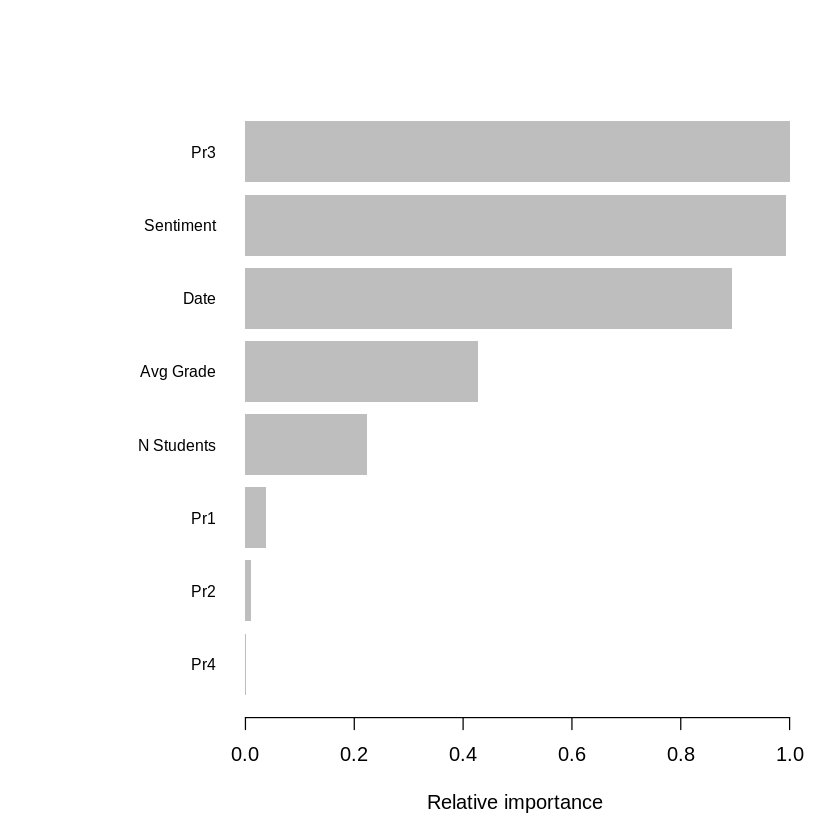

In [ ]:
importance_matrix <- xgb.importance(c("Pr1", "Pr2", "Pr3", "Pr4", "Sentiment", "N Students", "Date", "Avg Grade"), model = xgbc)

xgb.plot.importance(importance_matrix, rel_to_first = TRUE, xlab = "Relative importance")

# Comparing Classification Models

In [ ]:
install.packages("nnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(xgboost)
library(caret)
library(e1071)
library(nnet)



models_data = cbind(as.numeric(sapply(foo$Professor, encoder)), foo$Emojis_Handraises, foo$Judgement, foo$Number.of.Students, foo$Prof_Talk_Time, foo$Grades.Mean)
indexes = createDataPartition(models_data[,1], p=0.7, list=F)

train = models_data[indexes, ]
test = models_data[-indexes, ]

lm_train = foo[indexes,]
lm_test = foo[-indexes,]

train_x = train[,-1]
train_y = train[,1]

test_x = test[,-1]
test_y = test[,1]


xgb_train = xgb.DMatrix(data=train_x, label = train_y)
xgb_test = xgb.DMatrix(data=test_x, label = test_y)

In [ ]:
#LOGIT Model
logit = nnet::multinom(as.numeric(sapply(Professor, encoder)) ~Emojis_Handraises+Judgement+Number.of.Students+Prof_Talk_Time+Grades.Mean, family=binomial, data=lm_train)
logit_predict = predict(logit, lm_test)
logit_accuracy = sum(logit_predict == test_y) / length(test_y)
print(paste("Logit Accuracy:", logit_accuracy))
print(paste("Logit Recall"), recall(logit_predict, test_y))

#SVM Model
svm_model = svm(as.numeric(sapply(Professor, encoder)) ~Emojis_Handraises+Judgement+Number.of.Students+Prof_Talk_Time+Grades.Mean, data=lm_train, type="C-classification", kernel='linear')
svm_predict = predict(svm_model, lm_test)
svm_accuracy = sum(svm_predict == test_y) / length(test_y)
print(paste("SVM Accuracy:", svm_accuracy))
print(paste("SVM Recall"), recall(svm_predict, test_y))

#XGBOOST Model
xgbc = xgboost(data = xgb_train, max.depth = 5, nrounds = 70, verbose = F, num_class=4, objective="multi:softprob")
pred_prof = predict(xgbc, xgb_test, reshape=T)
pred_prof = as.data.frame(pred_prof)
colnames(pred_prof) = c(0:3)
pred_prof$Prediction = apply(pred_prof,1,function(x) colnames(pred_prof)[which.max(x)])

xgboost_accuracy = sum(pred_prof$Prediction == test_y) / length(test_y)
print(paste("XGBoost Accuracy:", xgboost_accuracy))

# weights:  28 (18 variable)
initial  value 49.906597 
iter  10 value 32.534077
iter  20 value 23.930002
iter  30 value 23.077670
iter  40 value 22.491584
iter  50 value 22.424842
iter  60 value 21.975471
iter  70 value 19.365132
iter  80 value 19.127144
iter  90 value 19.051390
iter 100 value 19.019688
final  value 19.019688 
stopped after 100 iterations
[1] "Logit Accuracy: 0.615384615384615"
[1] "Logit Recall"
[1] "SVM Accuracy: 0.615384615384615"
[1] "SVM Recall"
[21:52:24] WARNING: amalgamation/../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1] "XGBoost Accuracy: 0.461538461538462"


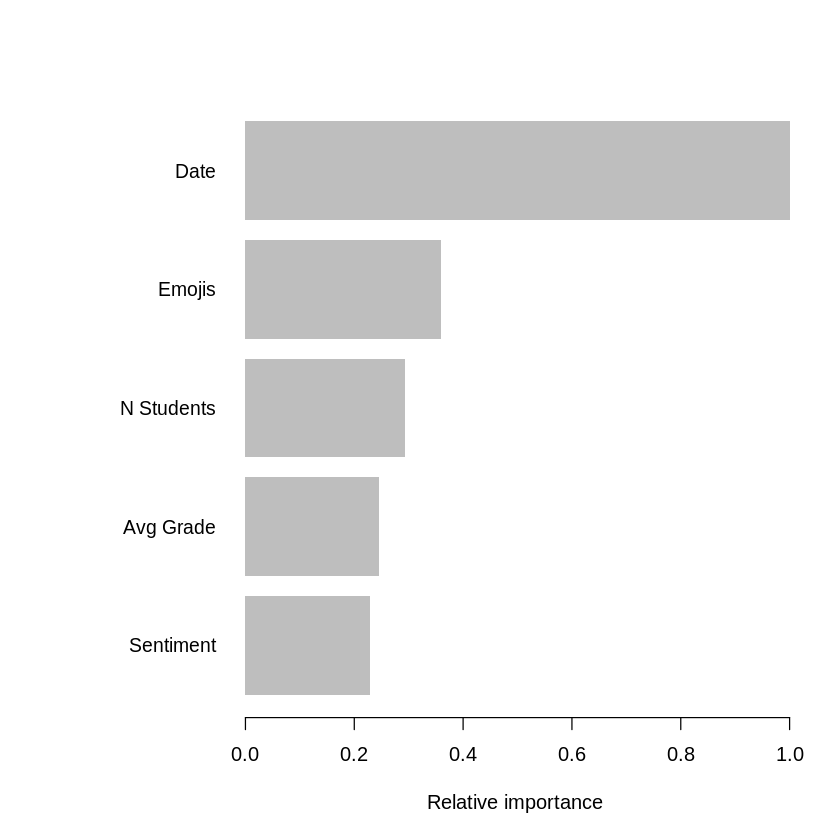

In [ ]:
importance_matrix <- xgb.importance(c("Emojis", "Sentiment", "N Students", "Date", "Avg Grade"), model = xgbc)
xgb.plot.importance(importance_matrix, rel_to_first = TRUE, xlab = "Relative importance")